# Whale Identification

The purpose of this model is create a whale identification model based on previous data. First step is prepare the data to be digested by the model.

# Organizing the Dataset

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
from itertools import combinations, chain
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
class WhaleDataset(Dataset):
    """
    Creates the dataset to train the model.
    """
    def __init__(self, csv_file, root_dir, transforms, split=.8, neg_ratio=2):
        """     
        Args: 
            root_dir (string): Path to diretory with images.
            csv_file (string): Path to csv with all the images.
            kind (string): train ratio of data.
            transforms (list): Optional list with train/test transforms to be applied to images.
            pos_ratio (float): Ratio of positive/negative matches present in dataset.
        """
        # Prepare DataFrame with the pair of images
        combined_pos_list = []
        whales_frame = pd.read_csv(csv_file)
        # Series with list of images for each ID
        pos_img_series = whales_frame.groupby('Id').agg(lambda x: ",".join(x)).drop("new_whale")["Image"]
        # Series of non-matching images
        false_img_series = whales_frame.groupby('Id').agg(lambda x: x.iloc[0])["Image"]
        # Calculates combinations of positive matches
        for idx, v in pos_img_series.iteritems():
            imgs = v.split(",")
            combined = combinations(imgs, 2)
            combined_pos_list.append(combined)
        
        # Positive matches
        positive = pd.DataFrame(list(chain(*combined_pos_list)), columns=["image_1", "image_2"])
        positive["label"] = 1
        
        # Calculates negative matches for all idx
        combined_neg = combinations(false_img_series, 2)
        combined_neg = list(combined_neg)[:neg_ratio * len(positive)]
        negative = pd.DataFrame(combined_neg, columns=["image_1", "image_2"])
        negative["label"] = 0
        
        
        # Join both frames
        self.data_raw = pd.concat([positive, negative], axis=0, join='outer', ignore_index=True)
        
        # Shuffle
        self.data_shuffled = self.data_raw.sample(frac=1).reset_index(drop=True).copy()
        # Split in train/test
        split_pos = int(len(self.data_raw) * split)
        self.train_data = self.data_shuffled.iloc[:split_pos, :]
        self.test_data = self.data_shuffled.iloc[split_pos:, :]
            
        self.root_dir = root_dir
        
        # Transforms
        self.transform = None
        self.transforms = transforms
        
        self.set_mode("train")
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Load images
        img_1_path = os.path.join(self.root_dir,
                                  self.data.iloc[idx, 0])
        img_2_path = os.path.join(self.root_dir,
                                  self.data.iloc[idx, 1])
        img_1 = Image.open(img_1_path).convert('RGB')
        img_2 = Image.open(img_2_path).convert('RGB')
        
        
        # Data augmentation
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
        
        # Label for image pair
        label = self.data.iloc[idx, 2]
        
        # Output
        sample = (img_1, img_2, label)
        
        return sample
    
    def set_mode(self, mode):
        if mode == "train":
            self.data = self.train_data
            self.transform = self.transforms[0]
        elif mode == "test":
            self.data = self.test_data
            self.transform = self.transforms[1]
        else:
            raise "Mode shoud be 'train' or 'test'."

In [3]:
csv_file = 'humpback-whale-identification/train.csv'
root_dir = 'humpback-whale-identification/train'
# data augmentation
train_transform = T.Compose([T.ColorJitter(.25, .25, .25,),
                             T.Resize(300),
                             T.RandomRotation(5),
                             T.FiveCrop((224)),
                             T.Lambda(lambda crops: torch.stack([T.ToTensor()(crop) for crop in crops]))
                            ])

test_transform = T.Compose([T.Resize(400),
                            T.FiveCrop((224)),
                            T.Lambda(lambda crops: torch.stack([T.ToTensor()(crop) for crop in crops]))
                           ])

whale_dataset = WhaleDataset(csv_file, root_dir, transforms=[train_transform, test_transform], neg_ratio=1)

In [4]:
data_loader = DataLoader(whale_dataset,
                         batch_size=1,
                         shuffle=True)

In [5]:
whale_dataset.set_mode("train")
len(whale_dataset)

111899

In [6]:
whale_dataset.set_mode("test")
len(whale_dataset)

27975

torch.Size([32, 5, 3, 224, 224])
tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 0])


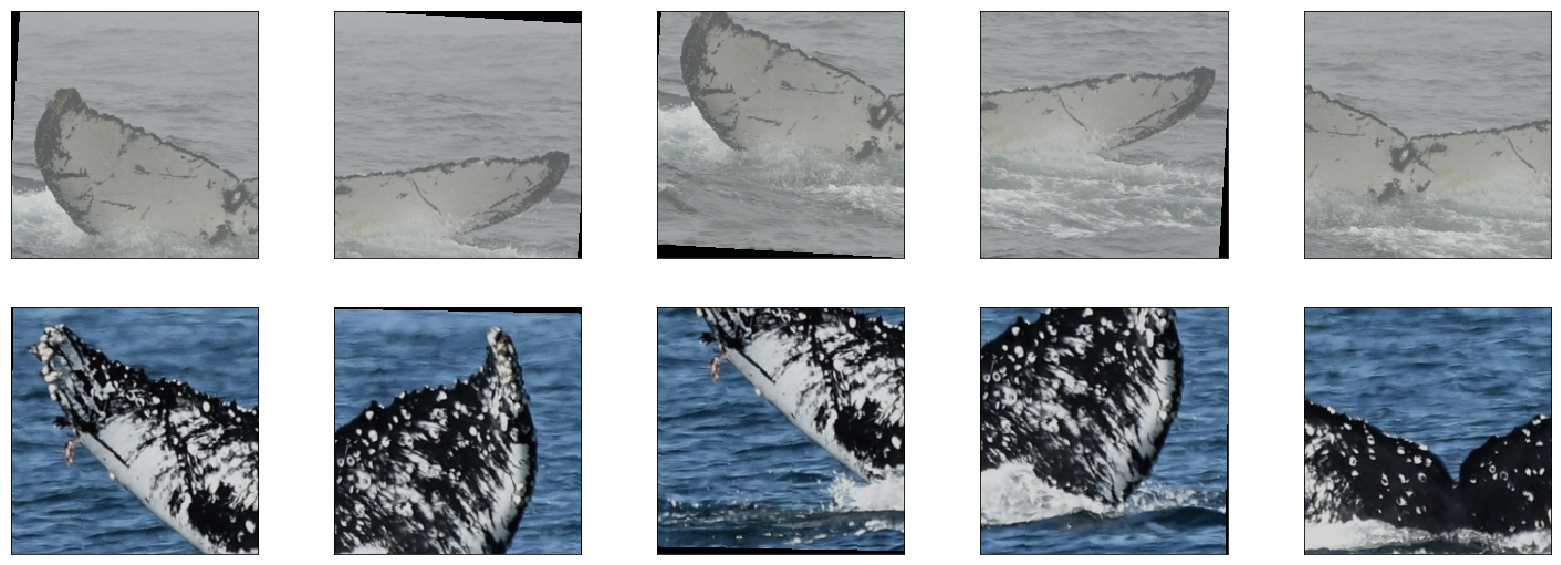

In [9]:
# Check data
img1, img2, label = iter(data_loader).next()

# 5 cropped images
print(img1.size())
bs, ncrops, c, h, w = img1.size()
# 1 item of the batch
imgs_1 = img1[0].numpy()
imgs_2 = img2[0].numpy()
f = plt.figure(figsize=(28, 10))
# For each crop
for idx in range(5):
    ax1 = f.add_subplot(2, 5, idx + 1, xticks=[], yticks=[])
    ax2 = f.add_subplot(2, 5, idx + 6, xticks=[], yticks=[])
    
    ax1.imshow(np.transpose(imgs_1[idx], (1, 2, 0)))
    ax2.imshow(np.transpose(imgs_2[idx], (1, 2, 0)))
print(label)


In [8]:

# Dataloader
data_loader = DataLoader(whale_dataset,
                         batch_size=32,
                         shuffle=True
                         )

In [7]:
whale_dataset.set_mode("train")
print(len(data_loader))

111899


In [10]:
whale_dataset.set_mode("test")
print(len(data_loader))

875


#### Reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

# Building and Training a Model

Model from the ground

The model will consist of a feture extrator for the whale pictures.

In [11]:
import torch
from torch import nn
from torch import optim
import torch.functional as F
from tqdm import tqdm

In [12]:
# Model
class WhaleSimilarity(nn.Module):
    """
    Network defining class.
    """
    def __init__(self):
        super(WhaleSimilarity, self).__init__()
        # Sequence of Convolution + Maxpool Layers
        self.features = nn.Sequential(nn.Conv2d(3, 8, 3, padding=1),  # sees 224x224x3 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(8, 16, 3, padding=1),  # sees 112x112x8 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(16, 32, 3, padding=1),  # sees 56x56x16 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(32, 48, 3, padding=1),  # sees 28x28x32 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2),
                                      nn.Conv2d(48, 80, 3, padding=1),  # sees 14x14x48 tensor
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2)  # outputs 7x7x80 tensor
                                     )
        # Linear layer with sigmoid
        self.fc = nn.Linear(80 * 7 * 7, 1)
        
    def forward(self, x1, x2):
        # Sequence of convolutional and max pooling layers
        x1 = self.features(x1)
        x2 = self.features(x2)
        
        # Flatten result
        x1 = x1.view(-1, 80 * 7 * 7)
        x2 = x2.view(-1, 80 * 7 * 7)
        
        # Subtrack results
        x = torch.abs(x1 - x2)
        # Linear neuron
        x = torch.sigmoid(self.fc(x))
        
        return x
    

In [13]:
# check if CUDA is available
train_device = 'cuda' if torch.cuda.is_available() else 'cpu'

if train_device == 'cpu':
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [14]:
# Defines Model
model = WhaleSimilarity()

model.to(train_device)

WhaleSimilarity(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(48, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3920, out_features=1, bias=True)
)

In [18]:
# Specify loss function (Binary Cross-entropy)
criterion = nn.BCELoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify lr scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Losses array
losses = {"train":[], "valid":[]}


In [19]:
# Auxiliary functions
def save_checkpoint(model, optimizer, scheduler, epoch, losses, file_name):
    """
    Saves the current model checkpoint;
    """
    # Saves the model
    checkpoint = {"model_state_dict": model.state_dict(),
                  "optim_state_dict": optimizer.state_dict(),
                  "scheduler_state_dict": scheduler.state_dict(),
                  "epoch": epoch,
                  "train_loss": losses["train"],
                  "valid_loss": losses["valid"]}
    torch.save(checkpoint, file_name)
    
def load_checkpoint(model, optimizer, scheduler, losses, file_name, location='cuda'):
    """
    Load all info from last model.
    """
    # Loads the model
    checkpoint = torch.load(file_name, map_location=location)
    
    # Load in given objects
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optim_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    losses["train"] = checkpoint["train_loss"]
    losses["valid"] = checkpoint["valid_loss"]
    

In [20]:
# save_checkpoint(model, optimizer, scheduler, 1, losses, 'whale_model_last.pth')
load_checkpoint(model, optimizer, scheduler, losses, 'whale_model_last.pth')

In [21]:
# number of epochs to train the model
n_epochs = 3
print_every = 100

valid_loss_min = np.Inf # track change in validation loss
# model = model.to(train_device).double()
for epoch in range(1, n_epochs + 1):
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    whale_dataset.set_mode("train")
    total_train = len(data_loader.dataset)
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for c, (img1, img2, target) in pbar:
        # move tensors to GPU if CUDA is available
        img1, img2, target = img1.to(train_device), img2.to(train_device), target.to(train_device).float()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Compesate 5 Crop
        bs, ncrops, c, h, w = img1.size()
        img1 = img1.view(-1, c, h, w)
        img2 = img2.view(-1, c, h, w)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(img1, img2)
        # Mean result of 5 crops
        output = output.view(bs, ncrops, -1).mean(1)
        # calculate the batch loss
        loss = criterion(output, target.view(-1, 1))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * bs
        # show partial results
        if c % print_every == 0:
            # print training/validation statistics 
            pbar.set_description('Batch: {:5d}/{:5d} Training Loss: {:2.6f}'.format(
            c,
            len(data_loader),
            train_loss / (bs * c)
            ))
        
    ######################    
    # validate the model #
    ######################
    whale_dataset.set_mode("test")
    total_test = len(data_loader.dataset)
    with torch.no_grad():
        for img1, img2, target in tqdm(data_loader, total=len(data_loader)):
            # move tensors to GPU if CUDA is available
            img1, img2, target = img1.to(train_device), img2.to(train_device), target.to(train_device).float()
            # Compesate 5 Crop
            bs, ncrops, c, h, w = img1.size()
            img1 = img1.view(-1, c, h, w)
            img2 = img2.view(-1, c, h, w)

            output = model(img1, img2)

            # Mean result of 5 crops
            output = output.view(bs, ncrops, -1).mean(1)
            # calculate the batch loss
            loss = criterion(output, target.view(-1, 1))
            # update average validation loss 
            valid_loss += loss.item() * bs
    
    # calculate average losses
    train_loss = train_loss / total_train
    valid_loss = valid_loss / total_test
    
    # Save losses
    losses["train"].append(train_loss)
    losses["valid"].append(valid_loss)
    
    # Save the model if validation loss has decreased
    save_model = False
    if valid_loss < valid_loss_min:
        # update the min_loss
        valid_loss_min = valid_loss
        # Saves the model
        checkpoint = {"model_state_dict": model.state_dict(),
                      "optim_state_dict": optimizer.state_dict(),
                      "scheduler_state_dict": scheduler.state_dict(),
                      "epoch": epoch,
                      "train_loss": losses["train"],
                      "valid_loss": losses["valid"]}
        torch.save(checkpoint, 'whale_model' + str(epoch) + '.pth')
        save_model = True

    # print training/validation statistics 
    print('Epoch: {:3d}/{:3d} Training Loss: {:2.6f} Validation Loss: {:2.6f} Saving Model: {}'.format(
        epoch,
        n_epochs,
        train_loss,
        valid_loss,
        save_model
        ))
    
    # Scheduler step
    scheduler.step(valid_loss)
   
    

100%|████████████████████████████████████████████████████████████████████████████████| 875/875 [22:41<00:00,  1.20s/it]


Epoch:   1/  3 Training Loss: 0.693329 Validation Loss: 0.693269 Saving Model: True


100%|████████████████████████████████████████████████████████████████████████████████| 875/875 [22:21<00:00,  1.18s/it]


Epoch:   2/  3 Training Loss: 0.693418 Validation Loss: 0.693217 Saving Model: True


100%|████████████████████████████████████████████████████████████████████████████████| 875/875 [23:22<00:00,  1.20s/it]


Epoch:   3/  3 Training Loss: 0.693383 Validation Loss: 0.693182 Saving Model: True


Using transfer learning as features extractors.

In [ ]:
# Load Pretrained Models

resnet50 = models.resnet50(pretrained=True)
resnet152 = models.resnet152(pretrained=True)

alexnet = models.alexnet(pretrained=True)

squeezenet = models.squeezenet1_0(pretrained=True)

vgg16 = models.vgg19(pretrained=True)
vgg19 = models.vgg19(pretrained=True)

densenet121 = models.densenet121(pretrained=True)
densenet161 = models.densenet161(pretrained=True)

inception3 = models.inception_v3(pretrained=True)

In [ ]:
# Add attributes to models
resnet152.name = 'ResNet_152'
resnet152.last_layer_attr = 'fc'

vgg19.name = 'VGG_19'
vgg19.last_layer_attr = 'classifier'

densenet161.name = 'DenseNet_161'
densenet161.last_layer_attr = 'classifier'

# List of Models and its last layer
transfer_models = [resnet152,
                    vgg19,
                    densenet161]